In [1]:
from io import BytesIO
import os
import pickle
from collections import defaultdict

import numpy as np


def load_embeddings(fast_path_dir, seg_embeddings_dir):
    print('Running get embeddings call')
    if fast_path_dir and os.path.exists(fast_path_dir):
        with open(fast_path_dir, 'rb') as f:
            embed_dict = pickle.load(f)

        print('Fast path')
        embeddings = embed_dict['average_embeddings']
        segment_ids_across_images = embed_dict['segment_ids']
        return embeddings, segment_ids_across_images

    print('No fast path sir')
    average_embeddings_across_images = []
    segment_ids_across_images = [] 
    # img_idx = []
    imgs = sorted(os.listdir(seg_embeddings_dir))
    img_to_vec_list = {}
    vector_idx = 0
    vec_to_img = [] # Maps vector index to image index

    for idx, seg_emb in enumerate(imgs):
        seg_emb_file = os.path.join(seg_embeddings_dir, seg_emb)
        with open(seg_emb_file, "rb") as f:
            dictionary = pickle.load(f)
    
        dictionary["average_embeddings"] = np.load(BytesIO(dictionary["average_embeddings"]))['a']
        average_embeddings = dictionary["average_embeddings"]
        segment_ids = dictionary["segment_ids"]

        if segment_ids[0] == 0:
            average_embeddings = average_embeddings[1:]
            segment_ids = segment_ids[1:]

        if len(average_embeddings) == 0:
            continue

        # Have a dictionary of image names pointing to the start and end index of the embeddings
        img_name = seg_emb.split('.pkl')[0]
        start_idx = vector_idx
        # end_idx = start_idx + len(average_embeddings) - 1
        end_idx = start_idx + len(average_embeddings)

        segment_id_idx = len(segment_ids_across_images)
        img_to_vec_list[img_name] = (start_idx, end_idx, segment_id_idx)
        for i in range(start_idx, end_idx):
            # vec_to_img.append(idx)
            vec_to_img.append(img_name)

        average_embeddings_across_images.append(average_embeddings)
        segment_ids_across_images.append(segment_ids)

        vector_idx += len(average_embeddings)
        # img_idx.append(idx)


    average_embeddings_across_images = np.vstack(average_embeddings_across_images)
    
    return average_embeddings_across_images, segment_ids_across_images, img_to_vec_list, vec_to_img

def create_new_pickle(seg_embed_dir, pickle_out_path='coco-2014-val-clip-embeds-fast-2.pkl'):
    if os.path.exists(pickle_out_path):
        with open(pickle_out_path, 'rb') as f:
            embed_dict = pickle.load(f)

        return embed_dict

    embeds, seg_ids, img_to_vec_list, vec_to_img = load_embeddings(None, seg_embed_dir)
    out_dict = {
        'average_embeddings': embeds, 
        'segment_ids': seg_ids, 
        'img_to_vec_list': img_to_vec_list,
        'vec_to_img': vec_to_img,
    }
    with open(pickle_out_path, "wb") as f:
        pickle.dump(out_dict, f)

    return out_dict

embed_base = '/data/users/jie/data-slicing/COCO/embeddings/'
embed_dir = os.path.join(embed_base, 'data/coco-2014-val-clip-embeds-532')
new_pickle_name = 'coco-2014-val-clip-embeds-fast-2.pkl'
new_pickle_path = os.path.join(embed_base, new_pickle_name)

embed_dict = create_new_pickle(embed_dir, new_pickle_path)
average_embeddings = embed_dict['average_embeddings']

In [2]:
import faiss


class CustomProductQuantizer:
    def __init__(self, dim, m, cluster_bits):
        self.dim = dim  # Total dimensionality of the vector
        self.m = m  # Number of subquantizers
        self.cluster_bits = cluster_bits  # Bits per subquantizer
        self.n_clusters = 2 ** cluster_bits  # Number of centroids per subquantizer
        self.sub_dim = dim // m  # Dimensionality of each subvector

        # Add these to make compatible with faiss
        self.M = m # number of subquantizers
        self.ksub = self.n_clusters # number of centroids per subquantizer
        self.dsub = self.sub_dim # dimension of each subvector

        # Create m KMeans clusterers
        self.kmeans_clusterers = [
            faiss.Kmeans(self.sub_dim, self.n_clusters, niter=20, verbose=False)
            for _ in range(self.m)
        ]
        self.centroids = None
        
    def train(self, residuals):
        centroids_list = []
        for i, clusterer in enumerate(self.kmeans_clusterers):
            start = i * self.sub_dim
            end = (i + 1) * self.sub_dim
            sub_vectors = residuals[:, start:end]
            clusterer.train(sub_vectors.astype(np.float32))
            centroids_list.append(clusterer.centroids)
        
        # Store centroids as a numpy array
        self.centroids = np.array(centroids_list)
    
    def compute_codes(self, residuals):
        # Adjust dtype according to number of cluster_bits
        dtable = [(8, np.uint8), (16, np.uint16), (32, np.uint32), (64, np.uint64)]
        # codes = np.zeros((residuals.shape[0], self.m), dtype=np.uint8)
        # codes = np.zeros((residuals.shape[0], self.m), dtype=dtable[self.cluster_bits // 8][1])
        dtype_index = 0
        while dtable[dtype_index][0] < self.cluster_bits:
            dtype_index += 1

        codes = np.zeros((residuals.shape[0], self.m), dtype=dtable[dtype_index][1])

        for i, clusterer in enumerate(self.kmeans_clusterers):
            start = i * self.sub_dim
            end = (i + 1) * self.sub_dim
            sub_vectors = residuals[:, start:end]
            _, sub_codes = clusterer.index.search(sub_vectors.astype(np.float32), 1)
            codes[:, i] = sub_codes.squeeze()
        return codes


In [3]:
import numpy as np
import faiss
from sklearn.metrics.pairwise import cosine_similarity

# Make sure to copy the CustomProductQuantizer class implementation here

def test_initialization():
    dim, m, cluster_bits = 128, 8, 8
    pq = CustomProductQuantizer(dim, m, cluster_bits)
    
    assert pq.dim == dim, f"Expected dim to be {dim}, but got {pq.dim}"
    assert pq.m == m, f"Expected m to be {m}, but got {pq.m}"
    assert pq.cluster_bits == cluster_bits, f"Expected cluster_bits to be {cluster_bits}, but got {pq.cluster_bits}"
    assert pq.n_clusters == 2**cluster_bits, f"Expected n_clusters to be {2**cluster_bits}, but got {pq.n_clusters}"
    assert pq.sub_dim == dim // m, f"Expected sub_dim to be {dim // m}, but got {pq.sub_dim}"
    assert len(pq.kmeans_clusterers) == m, f"Expected {m} kmeans clusterers, but got {len(pq.kmeans_clusterers)}"
    
    print("Initialization test passed!")

def test_train_and_compute_codes():
    dim, m, cluster_bits = 128, 8, 8
    pq = CustomProductQuantizer(dim, m, cluster_bits)
    
    np.random.seed(42)
    n_vectors = 100000
    data = np.random.randn(n_vectors, dim).astype(np.float32)
    
    pq.train(data)
    
    subset_size = 10000
    subset_data = data[:subset_size]
    codes = pq.compute_codes(subset_data)
    
    assert codes.shape == (subset_size, m), f"Expected codes shape to be {(subset_size, m)}, but got {codes.shape}"
    assert codes.dtype == np.uint8, f"Expected codes dtype to be uint8, but got {codes.dtype}"
    assert np.all(codes >= 0) and np.all(codes < 2**cluster_bits), "Codes are out of expected range"
    
    print("Train and compute codes test passed!")

def test_reconstruction_quality():
    dim, m, cluster_bits = 128, 8, 8
    pq = CustomProductQuantizer(dim, m, cluster_bits)
    
    np.random.seed(42)
    n_vectors = 100000
    data = np.random.randn(n_vectors, dim).astype(np.float32)
    
    pq.train(data)
    
    subset_size = 10000
    subset_data = data[:subset_size]
    codes = pq.compute_codes(subset_data)
    
    reconstructed = np.zeros((subset_size, dim), dtype=np.float32)
    for i in range(m):
        start = i * pq.sub_dim
        end = (i + 1) * pq.sub_dim
        centroids = pq.kmeans_clusterers[i].centroids
        reconstructed[:, start:end] = centroids[codes[:, i]]
    
    # Compute similarities between original and reconstructed vectors
    similarities = np.diagonal(cosine_similarity(subset_data, reconstructed))
    
    # Compute similarities between original and random vectors
    random_vectors = np.random.randn(subset_size, dim).astype(np.float32)
    random_similarities = np.diagonal(cosine_similarity(subset_data, random_vectors))
    
    avg_similarity = np.mean(similarities)
    min_similarity = np.min(similarities)
    max_similarity = np.max(similarities)
    
    avg_random_similarity = np.mean(random_similarities)
    min_random_similarity = np.min(random_similarities)
    max_random_similarity = np.max(random_similarities)
    
    print(f"Reconstruction quality metrics:")
    print(f"  Average cosine similarity: {avg_similarity:.4f}")
    print(f"  Minimum cosine similarity: {min_similarity:.4f}")
    print(f"  Maximum cosine similarity: {max_similarity:.4f}")
    print(f"\nRandom vectors similarity metrics:")
    print(f"  Average random cosine similarity: {avg_random_similarity:.4f}")
    print(f"  Minimum random cosine similarity: {min_random_similarity:.4f}")
    print(f"  Maximum random cosine similarity: {max_random_similarity:.4f}")
    
    assert avg_similarity > 0.6, f"Expected average similarity > 0.6, but got {avg_similarity:.4f}"
    assert min_similarity > 0.3, f"Expected minimum similarity > 0.3, but got {min_similarity:.4f}"
    assert avg_similarity > avg_random_similarity, f"Expected average similarity ({avg_similarity:.4f}) to be greater than average random similarity ({avg_random_similarity:.4f})"
    
    print("Reconstruction quality test passed!")

def test_compression_ratio():
    dim, m, cluster_bits = 128, 8, 8
    pq = CustomProductQuantizer(dim, m, cluster_bits)
    
    original_bytes = dim * 4  # 4 bytes per float32
    compressed_bytes = m * 1  # 1 byte per uint8 code
    compression_ratio = original_bytes / compressed_bytes
    
    print(f"Compression ratio: {compression_ratio:.2f}x")
    assert compression_ratio > 1, f"Expected compression ratio > 1, but got {compression_ratio:.2f}"
    
    print("Compression ratio test passed!")

def test_centroid_retrieval():
    dim, m, cluster_bits = 128, 8, 8
    pq = CustomProductQuantizer(dim, m, cluster_bits)
    
    np.random.seed(42)
    n_vectors = 10000
    data = np.random.randn(n_vectors, dim).astype(np.float32)
    
    pq.train(data)
    
    centroids = pq.centroids
    
    expected_shape = (m, 2**cluster_bits, dim // m)
    assert centroids.shape == expected_shape, f"Expected centroids shape {expected_shape}, but got {centroids.shape}"
    
    print("Centroid retrieval test passed!")

# Run the tests
test_initialization()
test_train_and_compute_codes()
test_reconstruction_quality()
test_compression_ratio()
test_centroid_retrieval()

Initialization test passed!
Train and compute codes test passed!
Reconstruction quality metrics:
  Average cosine similarity: 0.6570
  Minimum cosine similarity: 0.5855
  Maximum cosine similarity: 0.8831

Random vectors similarity metrics:
  Average random cosine similarity: 0.0015
  Minimum random cosine similarity: -0.3533
  Maximum random cosine similarity: 0.3067
Reconstruction quality test passed!
Compression ratio: 64.00x
Compression ratio test passed!
Centroid retrieval test passed!


In [4]:
import bitpacking

from tqdm import tqdm
import faiss

k_coarse = 512
m = 64
cluster_bits = 10
n_probes = 3

# Perform coarse-grain clustering with KMeans
embeddings = embed_dict['average_embeddings']
num_vectors, dim = embeddings.shape

# Create GPU Kmeans index
# kmeans = faiss.Kmeans(dim, k_coarse, niter=64, gpu=True)
# kmeans = faiss.Kmeans(dim, k_coarse, gpu=True)
kmeans = faiss.Kmeans(dim, k_coarse, niter=25)
kmeans.train(embeddings)

kms = []
d, cluster_ids = kmeans.index.search(embeddings, 1)
centroids = kmeans.centroids[cluster_ids].squeeze()
residuals = embeddings - centroids
# residuals = embeddings

# pqq = faiss.ProductQuantizer(dim, m, cluster_bits)
pqq = CustomProductQuantizer(dim, m, cluster_bits)
pqq.train(residuals)
codes = pqq.compute_codes(residuals)

packd = bitpacking.NumpyBitpackedDict()
n_imgs = len(embed_dict['img_to_vec_list'])
img_concept_bitmap = np.zeros((n_imgs, k_coarse), dtype=bool)
all_images = sorted(embed_dict['img_to_vec_list'])

packd_original_vectors = bitpacking.NumpyBitpackedDict()
# packd_original_vectors = defaultdict(list)

for img_idx, img_names in tqdm(enumerate(all_images)):
    start, end, segment_ids_idx = embed_dict['img_to_vec_list'][img_names]
    cluster_assignments = cluster_ids[start:end].flatten() # Cluster assignments
    residual_pq = codes[start:end]

    for concept, original_vector in zip(cluster_assignments, embeddings[start:end]):
        if (img_idx, concept) not in packd_original_vectors:
            packd_original_vectors[img_idx, concept] = [original_vector]
        else:
            packd_original_vectors[img_idx, concept].append(original_vector)

    for concept, pq in zip(cluster_assignments, residual_pq):
        img_concept_bitmap[img_idx, concept] = True
        if (img_idx, concept) not in packd:
            packd[img_idx, concept] = [pq]
        else:
            packd[img_idx, concept].append(pq)

# Baseline indexes
# 1) Flat index on GPU
res = faiss.StandardGpuResources()
index_flat = faiss.GpuIndexFlatL2(res, dim)
index_flat.add(embed_dict['average_embeddings'])
index_flat.train(embed_dict['average_embeddings'])

# 2) IVFPQ index on CPU
n_cells = k_coarse
nbits_per_idx = cluster_bits
quantizer = faiss.IndexFlatL2(dim)
index_pq = faiss.IndexIVFPQ(quantizer, dim, n_cells, m, nbits_per_idx)
index_pq.nprobe = n_probes
index_pq.train(embed_dict['average_embeddings'])
index_pq.add(embed_dict['average_embeddings'])
# For use in the search function. Must be accounted for in memory usage!
index_pq_codes = index_pq.reconstruct_n(0, len(embed_dict['average_embeddings']))

# 3) Flat index on CPU for original vectors
index_flat_cpu = faiss.IndexFlatL2(dim)
index_flat_cpu.add(embed_dict['average_embeddings'])
index_flat_cpu.train(embed_dict['average_embeddings'])

521 1024
521 1024


40501it [00:12, 3197.01it/s]


In [5]:
# bits = 10

# quantizer = faiss.IndexFlatL2(dim)
# # index_pq = faiss.IndexIVFPQ(quantizer, dim, n_cells, m, nbits_per_idx)
# index_pq = faiss.IndexIVFPQ(quantizer, dim, n_cells, m, bits)
# index_pq.nprobe = n_probes
# index_pq.train(embed_dict['average_embeddings'])
# index_pq.add(embed_dict['average_embeddings'])

# print(index_pq.invlists.__dir__())
# print('number of lists', index_pq.invlists.nlist)
# print('code size of iv', index_pq.invlists.code_size)
# # print(index_pq.invlists.get_codes)
# # index_pq.invlists.print_stats()

# def get_invlist(invlists, l):
#     """ returns the inverted lists content. 
#     That the data is *not* copied: if the inverted index is deallocated or changes, accessing the array may crash.
#     To avoid this, just clone the output arrays on output. 
#     """
#     ls = invlists.list_size(l)
#     list_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
#     list_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
#     return list_ids, list_codes

# print('--')
# # get content of inverted list #123
# list_ids, list_codes = get_invlist(index_pq.invlists, 511)
# print(bits, (np.max(list_codes)))
# print(len(np.unique(list_ids)))

In [6]:
d = 10
n = 400000
cs = 5
bits_time = 10
np.random.seed(123)
x = np.random.random(size=(n, d)).astype('float32')
testInputs=np.random.random(size=(1, d)).astype('float32')
print(testInputs)
pq = faiss.ProductQuantizer(d, cs, bits_time)
pq.verbose=True
pq.train(x)
codes=pq.compute_codes(testInputs)
#here expect 5 code range from 0-64, but get 4 and also code number not range 0-64
print(codes.shape)

bs = faiss.BitstringReader(faiss.swig_ptr(codes[0]), codes.shape[1])
for i in range(cs): 
    print(bs.read(bits_time))  # read 6 bits at a time

[[0.04429161 0.8824693  0.8059709  0.42052346 0.17886576 0.9699666
  0.7134032  0.75382024 0.4658185  0.11598542]]
Training PQ slice 0/5
Sampling a subset of 262144 / 400000 for training
Clustering 262144 points in 2D to 1024 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.01 s
  Iteration 24 (0.18 s, search 0.12 s): objective=41.8363 imbalance=1.020 nsplit=0       
Training PQ slice 1/5
Sampling a subset of 262144 / 400000 for training
Clustering 262144 points in 2D to 1024 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.01 s
  Iteration 24 (0.10 s, search 0.04 s): objective=42.3676 imbalance=1.032 nsplit=0       
Training PQ slice 2/5
Sampling a subset of 262144 / 400000 for training
Clustering 262144 points in 2D to 1024 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.01 s
  Iteration 24 (0.10 s, search 0.04 s): objective=42.131 imbalance=1.026 nsplit=0        
Training PQ slice 3/5
Sampling a subset of 262144 / 400000 for training
Clustering 262144 

In [7]:
index_flat_cpu = faiss.IndexFlatL2(dim)
index_flat_cpu.add(embed_dict['average_embeddings'])
index_flat_cpu.train(embed_dict['average_embeddings'])

In [8]:
m = pqq.M
dsub = pqq.dsub
# centroids = faiss.vector_to_array(pq.centroids).reshape(m, pq.ksub, dsub)
# faiss.vector_to_array(pqq.centroids).reshape(m, pqq.ksub, dsub).shape
pqq.centroids.reshape(m, pqq.ksub, dsub).shape

(64, 1024, 8)

In [9]:
import subprocess
import pickle
import os

maskclip_python = '/data/home/jxu680/miniconda3/envs/maskclip/bin/python3'

def get_text_features(text_list):
    # Create a temporary file to store the output
    temp_output_file = 'temp_clip_features.pkl'
    
    # Prepare the command
    command = [
        maskclip_python,
        'clip_encode.py',
        '--word_list'
    ] + text_list + [
        '--output_path',
        temp_output_file
    ]
    
    # Run the subprocess
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running clip_encode.py: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        return None

    # Load the pickle file
    try:
        with open(temp_output_file, 'rb') as f:
            feature_dict = pickle.load(f)
    except Exception as e:
        print(f"Error loading the output file: {e}")
        return None
    finally:
        # Clean up the temporary file
        if os.path.exists(temp_output_file):
            os.remove(temp_output_file)

    return feature_dict

In [10]:
features2 = get_text_features(["black dog", "white dog"])
# features2 = get_text_features(["black dog"])

In [11]:
# Find the closest centroid
import numpy as np
from collections import defaultdict
from heapq import heappush, heappushpop, nlargest

def cosine_distance(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2, ord=2)

def precision_at_k(gt, pred, k):
    """
    Compute the precision at k.
    """
    if len(pred) > k:
        pred = pred[:k]
    # print(pred)
    # print(gt)
    return len(set(gt) & set(pred)) / k

def calculate_precision(gt, pred):
    """
    Compute the Average Precision (AP).
    
    Args:
    gt (list): Ground truth list of relevant items.
    pred (list): Predicted list of items, sorted by relevance score (highest to lowest).
    
    Returns:
    float: The Average Precision score.
    """
    if not gt:
        return 0.0
    
    score = 0.0
    num_hits = 0.0
    gt_set = set(gt)
    
    for i, p in enumerate(pred):
        if p in gt_set and p not in pred[:i]:
            num_hits += 1
            score += num_hits / (i + 1)
    
    return score / len(gt)

def calculate_avg_precision(gt, pred):
    """
    Compute the Average Precision (AP) based on the given formula.
    
    Args:
    gt (list): Ground truth list of relevant items (documents).
    pred (list): Predicted list of items (documents), sorted by relevance score.
    
    Returns:
    float: The Average Precision score.
    """
    if not gt:
        return 0.0
    
    score = 0.0
    num_hits = 0.0
    relevant_items = set(gt)  # To check relevance
    total_relevant = len(relevant_items)  # Number of relevant items
    
    for i, p in enumerate(pred):
        if p in relevant_items:
            num_hits += 1
            precision_at_i = num_hits / (i + 1)  # Precision@i
            score += precision_at_i  # Add Precision@i to the score
    
    # Normalize by the total number of relevant items
    return score / total_relevant if total_relevant > 0 else 0.0

def compute_distance_table(pq, query):
    """
    Compute the distance table for a given query.
    This is similar to what FAISS does internally.
    """
    m = pq.M  # number of subquantizers
    ksub = pq.ksub  # number of centroids per subquantizer
    dsub = pq.dsub  # dimension of each subvector
    # m parts of size dsub
    query = query.reshape(m, dsub)
    # for each subvector, compute the distance to the centroids
    # distance_table[sub_vector_m, centroid_k] = distance between sub_vector_m and centroid_k
    distance_table = np.zeros((m, ksub), dtype=np.float32)
    # all the centroids, size m * ksub * dsub
    # reorganize the centroids to have m submatrices of size ksub * dsub
    # centroids = faiss.vector_to_array(pq.centroids).reshape(m, ksub, dsub)
    centroids = pq.centroids.reshape(m, ksub, dsub)
    for i in range(m):
        sub_query = query[i]
        sub_centroids = centroids[i]
        # distances (ksub,) = sum((ksub, dsub) - (dsub,) ^ 2, axis=1)
        distances = np.sum((sub_centroids - sub_query) ** 2, axis=1)
        distance_table[i, :] = distances # Distance of subvector i to all centroids

    return distance_table

def adc_distance(distance_table, codes):
    """
    Compute ADC distances using the precomputed distance table and PQ codes.
    """
    # Arrange steps through each "m" subvector
    # code selects the centroid for each subvector
    return np.sum(distance_table[np.arange(len(distance_table)), codes], axis=1)

def perform_search(features, p_k, exclusive_matching=False):
    """
    Perform our quantized search.
    Algorithm steps:
        1. For each feature (query), find the closest centroids for nprobes.
        2. Find the union of the closest centroids for each set of nprobes. (i.e. (dog_1 OR dog_2) AND (cat_1 OR cat_2))
        3. For each image, find distances between the segment embeddings (PQ'd) and our feature queries
        3.1 If exclusive_matching is True, then only allow features to match to single segment embeddings
        3.2 ELSE allow features to match to multiple segment embeddings
        4. For each image, find the closest segment embedding to each feature query
        5. Score images
        6. Return the sorted images
    """
    actual_centroids = kmeans.centroids
    closest_centroids = []
    key_to_concept_ids = defaultdict(list)

    for key, concept_feature in features.items():
        dist, cluster_ids = kmeans.index.search(concept_feature.reshape(1,-1), n_probes)
        dist = dist.flatten()
        cluster_ids = cluster_ids.flatten()
        closest_centroids.append((dist, cluster_ids))
        for i, cluster_id in enumerate(cluster_ids):
            key_to_concept_ids[key].append(cluster_id)

    # For each query, union the images that match the closest centroids
    centroid_candidates = []
    for query_i, (_, cluster_ids) in enumerate(closest_centroids):
        # OR operation within each query's cluster ids
        query_matches = np.any(img_concept_bitmap[:, cluster_ids], axis=1)
        centroid_candidates.append(query_matches)

    # AND operation across all queries
    matching_images = np.where(np.all(centroid_candidates, axis=0))[0]

    # Compute distance table for each [feature_key, concept]
    # If this concept closest to this 
    concept_d_table = {}
    for key, concept in features.items():
        relevant_concept_ids = key_to_concept_ids[key]
        for concept_idx in relevant_concept_ids:
            concept_residual = concept - actual_centroids[concept_idx]
            # (feature, centroids)
            concept_d_table[key, concept_idx] = compute_distance_table(pqq, concept_residual)

    # print("Step 5")
    all_distances = {}
    for img_idx in matching_images:
        for key in features:
            for concept_idx in key_to_concept_ids[key]:
                if not img_concept_bitmap[img_idx, concept_idx]:
                    continue

                pq_vectors = np.array(packd[img_idx, concept_idx])
                # Calculate distances using ADC
                adc_distances = adc_distance(concept_d_table[key, concept_idx], pq_vectors)
                closest_pq_vector_index = np.argmin(adc_distances)
                closest_pq_vector_distance = adc_distances[closest_pq_vector_index]

                if (img_idx, key) not in all_distances:
                    all_distances[(img_idx, key)] = closest_pq_vector_distance
                else:
                    if closest_pq_vector_distance < all_distances[(img_idx, key)]:
                        all_distances[(img_idx, key)] = closest_pq_vector_distance

    all_keys = set(features.keys())
    img_distances = []
    img_distance_counter = {}
    
    for img_idx in matching_images:
        distance = 0
        counter = 0
        for key in all_keys:
            if (img_idx, key) in all_distances:
                distance += all_distances[(img_idx, key)]
                counter += 1
        
        # Heap uses negative distance to simulate a max heap
        # Furthest images (larger distance -> smaller heap value) will be popped first
        if len(img_distances) < p_k:
            heappush(img_distances, (-distance, img_idx))
        elif -distance > img_distances[0][0]:
            # Heap is full and we are closer than the furthest image
            heappushpop(img_distances, (-distance, img_idx))
        
        img_distance_counter[img_idx] = counter
    
    # Convert heap to sorted list of top p_k images
    image_distances_named = {img_idx: -dist for dist, img_idx in img_distances}
    sorted_images = [all_images[idx] for _, idx in nlargest(p_k, img_distances)]
    return sorted_images, image_distances_named

# Multi-concept Search with FlatIndex (or PQIndex)
* For each concept, perform NN-search.
* Expand knn count until top-k candidates are found or until max neighbor search is hit

In [12]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2, ord=2)

def cosine_distance(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def flat_multisearch(search_index, features, embed_source, p_k, 
                     vec_to_img, img_to_vec_list,
                     max_search_radius=1e5, exclusive_matching=False, 
                     distance_fn=euclidean_distance):
    '''
    Perform multi-vector flat search.

    Args:
    search_index: Index to search on.
    features (dict): Dictionary of features to search for. [Key: np.array]
    embed_source (np.array): Source of embeddings to search on.
    p_k (int): Precision at k setting.
    vec_to_img (list): Mapping of vector index to image index.
    img_to_vec_list (dict): Mapping of image index to start and end index of vectors.
    max_search_radius (float): Maximum search radius for the search.
    exclusive_matching (bool): If True, features cannot map to same concept in 
        image. Use Hungarian matching to minimize distance.
    '''
    candidates = set()
    search_radius = p_k
    while len(candidates) < p_k:
        if search_radius >= max_search_radius:
            break
        potential_candidates = []
        for key, feature in features.items():
            dist, idxs = search_index.search(feature.reshape(1, -1), search_radius)
            img_names = set(vec_to_img[idx] for idx in idxs[0])
            # img_names = set(embed_dict['vec_to_img'][idx] for idx in idxs[0])
            potential_candidates.append(img_names)

        candidates = set.intersection(*potential_candidates)
        search_radius *= 2

    if len(candidates) < p_k:
        print(f"Only found {len(candidates)} candidates, returning all")
    else:
        print("Found candidates at search radius", search_radius)

    print(len(candidates))

    # Score each set of candidates
    img_scores = {}
    for img in candidates:
        start_idx, end_idx, segment_id_idx = img_to_vec_list[img]
        # start_idx, end_idx, segment_id_idx = embed_dict['img_to_vec_list'][img]
        # seg_embed = embed_dict['average_embeddings'][start_idx:end_idx]
        # seg_embed = index_pq_codes[start_idx:end_idx]
        seg_embed = embed_source[start_idx:end_idx]
        
        if exclusive_matching:
            cost_matrix = np.zeros((len(features), len(seg_embed)))
            for i, (key, feature) in enumerate(features.items()):
                for j, embed in enumerate(seg_embed):
                    cost_matrix[i, j] = distance_fn(feature, embed)
            
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            total_cost = cost_matrix[row_ind, col_ind].sum()
            img_scores[img] = total_cost
        else:
            img_scores[img] = {}
            for key, feature in features.items():
                img_scores[img][key] = min(distance_fn(feature, embed) for embed in seg_embed)

    if exclusive_matching:
        sorted_images = sorted(img_scores.items(), key=lambda x: x[1])
    else:
        img_total_scores = {img: sum(scores.values()) for img, scores in img_scores.items()}
        sorted_images = sorted(img_total_scores.items(), key=lambda x: x[1])

    # print(sorted_images[:p_k])
    return [img for img, _ in sorted_images[:p_k]]


In [13]:
import pympler

test_idx = faiss.IndexFlatL2(dim, )

In [14]:
print(faiss.cvar.indexIVF_stats.__dir__())
print(faiss.cvar.indexIVF_stats.nq, 'is nq')
print(faiss.cvar.indexIVF_stats.ndis, 'is ndis')
print(faiss.cvar.indexIVF_stats.nheap_updates, 'is nheap_updates')

['this', '__module__', 'thisown', '__repr__', 'nq', 'nlist', 'ndis', 'nheap_updates', 'quantization_time', 'search_time', '__init__', 'reset', 'add', '__swig_destroy__', '__dict__', '__weakref__', '__doc__', '__new__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
0 is nq
0 is ndis
0 is nheap_updates


In [16]:
our_search_results, all_img_distances = perform_search(features2, 10, exclusive_matching=True)
search_results_flat = flat_multisearch(index_flat_cpu, features2, average_embeddings, 10, exclusive_matching=False)
search_results = flat_multisearch(index_pq, features2, index_pq_codes, 10, exclusive_matching=False)

Found candidates at search radius 640
19
Found candidates at search radius 320
24


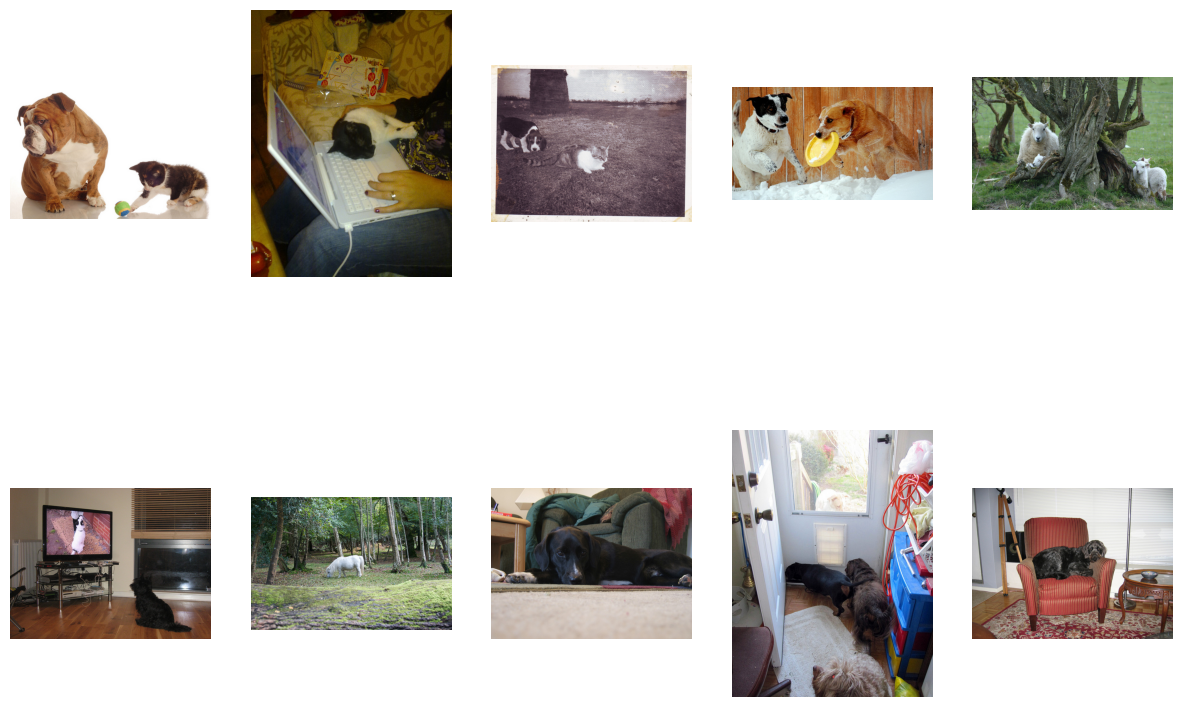

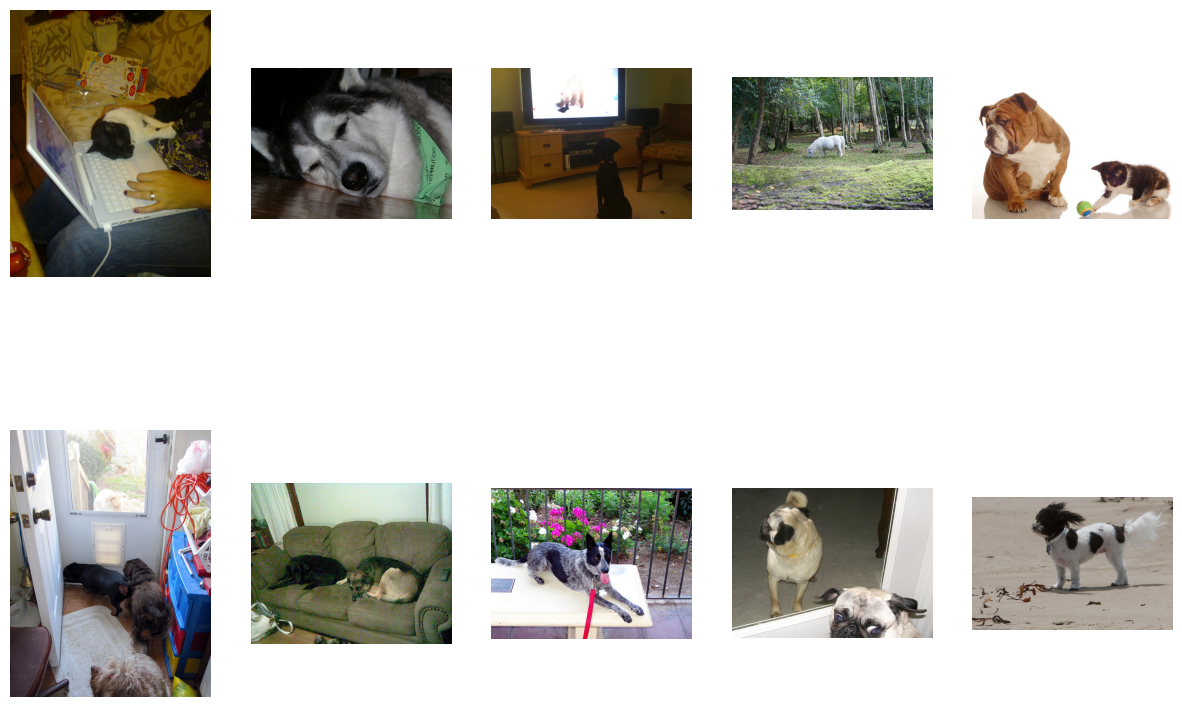

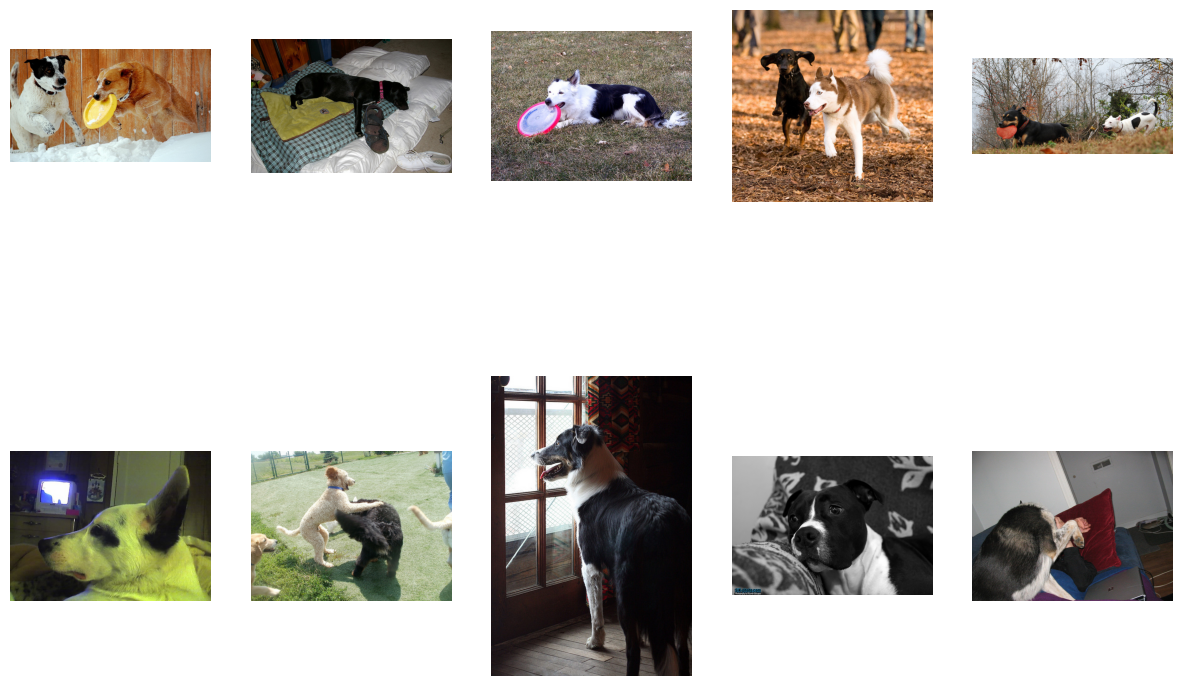

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

coco_img_dir = '/data/users/jie/data-slicing/COCO/val2014/'

def plot_images(images, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    for img, ax in zip(images, axes.ravel()):
        img_data = Image.open(os.path.join(coco_img_dir, img))
        ax.imshow(img_data)
        ax.axis('off')

    plt.show()

plot_images(our_search_results, n_cols=5)
plot_images(search_results, n_cols=5)
plot_images(search_results_flat, n_cols=5)


In [19]:
import random

all_ap = {
    'ours': [],
    'pq': []
}
p_k=25
for i in range(50):
    f = {'v': average_embeddings[random.randint(0, len(average_embeddings) - 1)]}
    my_images, _ = perform_search(f, p_k=p_k, exclusive_matching=False)
    gt_images = flat_multisearch(index_flat_cpu, f, average_embeddings, p_k,  exclusive_matching=True)
    pq_images = flat_multisearch(index_pq, f, index_pq_codes, p_k, exclusive_matching=True)

    my_ap = calculate_avg_precision(gt_images, my_images)
    pq_ap = calculate_avg_precision(gt_images, pq_images)
    print(f"AP for our method: {my_ap}")
    print(f"AP for PQ: {pq_ap}")
    all_ap['ours'].append(my_ap)
    all_ap['pq'].append(pq_ap)



# Summarize the results
faiss_ap = np.array(all_ap['ours'])
pq_ap = np.array(all_ap['pq'])

print(f"Average AP for our method: {np.mean(faiss_ap)}")
print(f"Average AP for PQ: {np.mean(pq_ap)}")


Found candidates at search radius 100
44
Found candidates at search radius 100
44
AP for our method: 0.6495766292530999
AP for PQ: 0.6413036414565826
Found candidates at search radius 100
41
Found candidates at search radius 100
42
AP for our method: 0.780147636684519
AP for PQ: 0.7839539647487015
Found candidates at search radius 100
48
Found candidates at search radius 100
46
AP for our method: 0.2961212121212121
AP for PQ: 0.3813524384112619
Found candidates at search radius 100
44
Found candidates at search radius 100
47
AP for our method: 0.6053903547432959
AP for PQ: 0.5570937950937951
Found candidates at search radius 100
48
Found candidates at search radius 100
48
AP for our method: 0.7735095314042683
AP for PQ: 0.7545454545454545
Found candidates at search radius 50
25
Found candidates at search radius 50
25
AP for our method: 0.4171682665160926
AP for PQ: 0.2872344322344322
Found candidates at search radius 50
25
Found candidates at search radius 50
25
AP for our method: 0.76

In [21]:
all_images = list(embed_dict['img_to_vec_list'].keys())

for n_segments in [2,4,6]:
    all_ap = {
        'ours': [],
        'pq': []
    }

    for _ in range(30):
        random_img = random.choice(all_images)
        start_idx, end_idx, _ = embed_dict['img_to_vec_list'][random_img]
        img_embeddings = average_embeddings[start_idx:end_idx]
        # random_embedding_idx = random.sample(range(len(img_embeddings)), n_segments)
        random_embedding_idx = random.sample(range(len(img_embeddings)), min(n_segments, len(img_embeddings)))
        
        features = {f'v_{i}': img_embeddings[idx] for i, idx in enumerate(random_embedding_idx)}
        
        our_images, _ = perform_search(features, p_k=p_k, exclusive_matching=False)
        gt_images = flat_multisearch(index_flat_cpu, features, average_embeddings, p_k, exclusive_matching=False)
        pq_images = flat_multisearch(index_pq, features, index_pq_codes, p_k, exclusive_matching=False)

        our_ap = calculate_avg_precision(gt_images, our_images)
        pq_ap = calculate_avg_precision(gt_images, pq_images)
        
        all_ap['ours'].append(our_ap)
        all_ap['pq'].append(pq_ap)

        print(all_ap)

    # Summarize the results
    print(f"Number of segments: {n_segments}")
    our_ap = np.array(all_ap['ours'])
    pq_ap = np.array(all_ap['pq'])

    print(f"Average AP for our method: {np.mean(our_ap):.4f} ± {np.std(our_ap):.4f}")
    print(f"Average AP for PQ: {np.mean(pq_ap):.4f} ± {np.std(pq_ap):.4f}")
    print()



Found candidates at search radius 3200
43
Found candidates at search radius 3200
31
{'ours': [0.29073015873015867], 'pq': [0.20723809523809525]}
Found candidates at search radius 800
25
Found candidates at search radius 800
30
{'ours': [0.29073015873015867, 0.12066666666666666], 'pq': [0.20723809523809525, 0.13454545454545455]}
Found candidates at search radius 1600
30
Found candidates at search radius 3200
55
{'ours': [0.29073015873015867, 0.12066666666666666, 0.20416666666666664], 'pq': [0.20723809523809525, 0.13454545454545455, 0.21790476190476188]}
Found candidates at search radius 200
31
Found candidates at search radius 200
31
{'ours': [0.29073015873015867, 0.12066666666666666, 0.20416666666666664, 0.7812380503987719], 'pq': [0.20723809523809525, 0.13454545454545455, 0.21790476190476188, 0.8673717931191613]}
Found candidates at search radius 800
47
Found candidates at search radius 800
46
{'ours': [0.29073015873015867, 0.12066666666666666, 0.20416666666666664, 0.7812380503987719,

In [48]:
import pympler
import pympler.classtracker

tr = pympler.classtracker.ClassTracker()

k_coarse = 512
cluster_bits = 8
m = 64
dim = average_embeddings.shape[1]
n_probes = 1


n_cells = k_coarse
nbits_per_idx = cluster_bits
quantizer = faiss.IndexFlatL2(dim)
index_pq = faiss.IndexIVFPQ(quantizer, dim, n_cells, m, nbits_per_idx)
tr.track_class(faiss.IndexIVFPQ)
tr.create_snapshot()

index_pq.nprobe = n_probes
index_pq.train(embed_dict['average_embeddings'])
tr.create_snapshot()
index_pq.add(embed_dict['average_embeddings'])
tr.create_snapshot()

tr.stats.print_summary()

---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
                                         active      0     B      average   pct
                                         active      0     B      average   pct
-------------------------------------------------------------------------------


In [52]:
faiss.get_memory()

AttributeError: module 'faiss' has no attribute 'get_memory'